In [148]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

import cv2
%matplotlib inline

<img src="./segnet.png">

In [149]:
class Encoder(nn.Module):
    def __init__(self, in_channels):
        super(Encoder, self).__init__()

        batchNorm_momentum = 0.1

        self.encode1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True),
        )

        self.encode2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True),
        )

        self.encode3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True),
        )

        self.encode4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True),
        )

        self.encode5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        idx = []

        x = self.encode1(x)
        x, id1 = F.max_pool2d_with_indices(x, kernel_size=2, stride=2, return_indices=True)
        idx.append(id1)

        x = self.encode2(x)
        x, id2 = F.max_pool2d_with_indices(x, kernel_size=2, stride=2, return_indices=True)
        idx.append(id2)

        x = self.encode3(x)
        x, id3 = F.max_pool2d_with_indices(x, kernel_size=2, stride=2, return_indices=True)
        idx.append(id3)

        x = self.encode4(x)
        x, id4 = F.max_pool2d_with_indices(x, kernel_size=2, stride=2, return_indices=True)
        idx.append(id4)

        x = self.encode5(x)
        x, id5 = F.max_pool2d_with_indices(x, kernel_size=2, stride=2, return_indices=True)
        idx.append(id5)

        return x, idx


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        batchNorm_momentum = 0.1
        out_channels = 1

        self.decode1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True)
        )

        self.decode2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True)
        )

        self.decode3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True)
        )

        self.decode4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True)
        )

        self.decode5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64, momentum=batchNorm_momentum),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x, idx):
        x = F.max_unpool2d(x, idx[4], kernel_size=2, stride=2)
        x = self.decode1(x)
        
        x = F.max_unpool2d(x, idx[3], kernel_size=2, stride=2)
        x = self.decode2(x)
        
        x = F.max_unpool2d(x, idx[2], kernel_size=2, stride=2)
        x = self.decode3(x)
        
        x = F.max_unpool2d(x, idx[1], kernel_size=2, stride=2)
        x = self.decode4(x)
        
        x = F.max_unpool2d(x, idx[0], kernel_size=2, stride=2)
        x = self.decode5(x)

        return x


class CostMapGenerator(nn.Module):
    # 网络结构是借鉴segnet
    # https://arxiv.org/abs/1511.00561
    def __init__(self):
        super(CostMapGenerator, self).__init__()

        self.encode = Encoder(in_channels=3)
        self.decode = Decoder()
        
        # self.decode = 
        
        self.activate = nn.Tanh() # Sigmoid()
        # 初始化网络参数
        self.initialize_weights()

    def forward(self, x):
        x, idx = self.encode(x)
        # print(x.shape)
        x = self.decode(x, idx)
        cost_map = self.activate(x)
        cost_map = (cost_map + 1)/2
        return cost_map
    

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    

torch.Size([1, 3, 512, 1024])

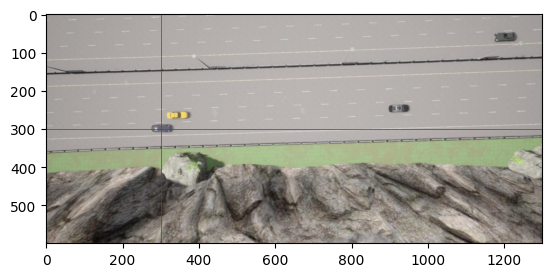

In [150]:
import torchvision.transforms as transforms
img_transform = transforms.Compose([
    transforms.Resize((512,1024)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# input_image = torch.randn((1, 3, 256, 256))  # 示例输入图像
from PIL import Image
raw_image = Image.open('./003640.jpg').convert('RGB')

input_image = img_transform(raw_image).unsqueeze(0)
bs, c, h, w = input_image.shape


plt.imshow(raw_image)
# plt.plot([0,1023],[256,256],'r-',lw=0.5)
# plt.plot([256,256],[0,511],'r-',lw=0.5)
plt.plot([0,1299],[300,300],'r-',lw=0.5)
plt.plot([300,300],[0,599],'r-',lw=0.5)

input_image.shape

In [151]:
model = CostMapGenerator()

model.eval()
# 获得输出costmap
output_costmap = model(input_image)

# 打印输出costmap的形状和值
print("输出costmap的形状:", output_costmap.shape)
print("输出costmap的值范围:", torch.min(output_costmap), "到", torch.max(output_costmap))


costmap_arr = output_costmap.squeeze(0).permute(1, 2, 0).detach().numpy()
plt.imshow(costmap_arr)

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 33554432 bytes.

In [152]:

# 轨迹
x0 = 1024*300/1300
y0 = 512*300/600
xx = torch.linspace(x0,x0+400,50)
yy = torch.linspace(y0,y0-10,50)
tgt_traj = torch.column_stack((xx,yy)).unsqueeze(0)

traj_dataset = [tgt_traj]
tgt_traj.shape

torch.Size([1, 50, 2])

In [144]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

In [147]:
# H表示网络认为目标点在这个栅格, P(H)表示先验分布，P(H|D)是后验分布
# D表示数据集中目标点在这个栅格，P(D)表示总体似然概率，P(D|H)表示似然概率
# P(D)被暗含在数据集的分布里面了
device = torch.device('cpu')
model = model.to(device)
model.train()

for epoch in range(100):
    print("epoch:",epoch)
    for image, tgt_traj in zip([input_image], traj_dataset):
        
        
        input_image = input_image.to(device)
        costmap = model(input_image)
        
        
        
        prior = costmap # 先验分布  prior.clone().detach().cpu()
        likelihood = torch.ones_like(prior)*0.5 # 这里其实不太对，应该把轨迹点连线，不是每个轨迹点
        # likelihood = likelihood.squeeze(1)
        for l, tgt in zip(likelihood, tgt_traj): # batch中每一个
            gamma = 0.98
            confidence = 1
            for i in range(len(tgt)-1, 0, -1): #每个时间步
                x1, y1 = int(round(tgt[i-1,0].item())), int(round(tgt[i-1,1].item()))
                x2, y2 = int(round(tgt[i,0].item())), int(round(tgt[i,1].item()))
                # cv2.line(l,(x1,y1),(x2,y2),color=confidence,thickness=1
                k = (y2-y1)/(x2-x1)
                xx = list(range(x1,x2+1,1)) if x2>x1 else list(range(x2,x1-1,-1))
                yy = [int(round(y1 + k*(x-x1))) for x in xx]
                for x,y in zip(xx,yy):
                    l[0,y,x] = max([confidence,0.5])
                    # l[0,y-50:y+50,x-50:x+50] = max([confidence,0.5])
                confidence *= gamma
            # for i in range(len(tgt)-1, -1, -1): #每个时间步
            #     x, y = int(round(tgt[i,0])), int(round(tgt[i,1]))
            #     l[0,y,x] = max([confidence,l[0,y,x]) #confidence if confidence>l[0,y,x] else l[0,y,x]
            #     confidence *= gamma
            
        
        # likelihood = likelihood.unsqueeze(1)
        post = likelihood * prior # 没有归一化的
        # print(torch.sum(prior)/torch.sum(post))
        # post *= torch.sum(prior)/torch.sum(post)
        post *= 2
        post = torch.clip(post,0,1)
        
        # loss = criterion(costmap.cpu(),post.cpu())
        loss = criterion(costmap.cpu(),likelihood.cpu())
        print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
        # plt.figure()
        # costmap_arr = costmap.squeeze(0).permute(1, 2, 0).detach().numpy()
        # plt.imshow(costmap_arr)
        # plt.figure()
        # likelihood_arr = likelihood.squeeze(0).permute(1, 2, 0).detach().numpy()
        # plt.imshow(likelihood_arr)
        # plt.figure()
        # post_arr = post.squeeze(0).permute(1, 2, 0).detach().numpy()
        # plt.imshow(post_arr)

epoch: 0


RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 134217728 bytes.

输出costmap的形状: torch.Size([1, 1, 512, 1024])
输出costmap的值范围: tensor(0.5001, grad_fn=<MinBackward1>) 到 tensor(0.5001, grad_fn=<MaxBackward1>)


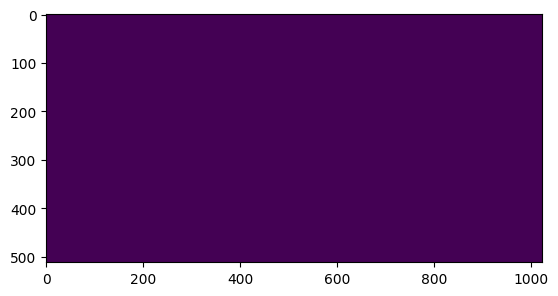

In [134]:
model.eval()
output_costmap = model(input_image)
output_costmap = output_costmap.cpu()

print("输出costmap的形状:", output_costmap.shape)
print("输出costmap的值范围:", torch.min(output_costmap), "到", torch.max(output_costmap))

costmap_arr = output_costmap.squeeze(0).permute(1, 2, 0).detach().numpy()
plt.imshow(costmap_arr)

In [123]:
tgt = tgt_traj[0]
# torch.flip(tgt,)
# tgt[::-1]
len(tgt)

tgt[i-1,0].item()

236.3076934814453

In [60]:
costmap

tensor([[[[0.4504, 0.4504, 0.4504,  ..., 0.4504, 0.4504, 0.4504],
          [0.4504, 0.4504, 0.4504,  ..., 0.4504, 0.4504, 0.4504],
          [0.4504, 0.4504, 0.4504,  ..., 0.4504, 0.4504, 0.4504],
          ...,
          [0.4504, 0.4504, 0.4504,  ..., 0.4504, 0.4504, 0.4504],
          [0.4504, 0.4504, 0.4504,  ..., 0.4504, 0.4504, 0.4504],
          [0.4504, 0.4504, 0.4504,  ..., 0.4504, 0.4504, 0.4504]]]],
       grad_fn=<DivBackward0>)

In [62]:
post.max()


tensor(0.9007, grad_fn=<MaxBackward1>)

In [10]:
costmap


tensor([[[[0.5050, 0.5050, 0.5050,  ..., 0.5050, 0.5050, 0.5050],
          [0.5050, 0.5050, 0.5050,  ..., 0.5050, 0.5050, 0.5050],
          [0.5050, 0.5050, 0.5050,  ..., 0.5050, 0.5050, 0.5050],
          ...,
          [0.5050, 0.5050, 0.5050,  ..., 0.5050, 0.5050, 0.5050],
          [0.5050, 0.5050, 0.5050,  ..., 0.5050, 0.5050, 0.5050],
          [0.5050, 0.5050, 0.5050,  ..., 0.5050, 0.5050, 0.5050]]]],
       grad_fn=<ToCopyBackward0>)

In [131]:
likelihood

tensor([[[[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]]]])

In [39]:
post.max()

tensor(1., grad_fn=<MaxBackward1>)

In [50]:
(post-costmap).max()

tensor(0.5000, grad_fn=<MaxBackward1>)

In [40]:
loss = criterion(torch.Tensor([0.5]),torch.Tensor([0.5]),)

loss

tensor(0.)